<a href="https://colab.research.google.com/github/hamidpeywasti/ML-From-Scratch/blob/master/plantvillage38_2path_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
monitor='val_accuracy'
epochs=75
batch_size=32
input_shape=(224, 224, 3) # please resize it to (224,224,3) if you have enough RAM
Verbose=True

In [2]:
#apt-get install git python3-opencv
import os

if not os.path.isdir('k'):
  !git clone https://github.com/joaopauloschuler/k-neural-api.git k
else:
  !cd k && git pull

!cd k && pip install .

!rm -rf k

Cloning into 'k'...
remote: Enumerating objects: 1832, done.
remote: Counting objects: 100% (244/244), done.
remote: Compressing objects: 100% (169/169), done.
remote: Total 1832 (delta 152), reused 152 (delta 71), pack-reused 1588
Receiving objects: 100% (1832/1832), 15.73 MiB | 22.56 MiB/s, done.
Resolving deltas: 100% (1265/1265), done.
Processing /content/k
  Preparing metadata (setup.py) ... done
  Created wheel for cai: filename=cai-0.1.7-py3-none-any.whl size=61376 sha256=01f4e506ee5c3b95d65c14d6c5532352a507f63f848afbfb8d8ad9b2183b6c62
  Stored in directory: /tmp/pip-ephem-wheel-cache-uqey47b6/wheels/80/61/f5/947bedc7e497038def7d1381fb65d37bd126a80e010114b8f1
Successfully built cai
  Attempting uninstall: cai
    Found existing installation: cai 0.1.7
    Uninstalling cai-0.1.7:
      Successfully uninstalled cai-0.1.7


In [3]:
import sys
print("Python version:", sys.version)

import skimage
print('skimage:',  skimage.__version__)

import tensorflow as tf
print('Tensorflow:',tf.__version__)

import cai
import cai.datasets
import cai.models

import multiprocessing
import os

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

Python version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
skimage: 0.19.3
Tensorflow: 2.15.0


In [4]:
url_zip_file="https://data.mendeley.com/datasets/tywbtsjrjv/1/files/d5652a28-c1d8-4b76-97f3-72fb80f94efc/Plant_leaf_diseases_dataset_without_augmentation.zip?dl=1"
local_zip_file="plant_leaf.zip"
expected_folder_name="plant_leaf"
Verbose=True
cai.datasets.download_zip_and_extract(
    url_zip_file=url_zip_file, local_zip_file=local_zip_file,
    expected_folder_name=expected_folder_name, Verbose=Verbose)

Downloading:  https://data.mendeley.com/datasets/tywbtsjrjv/1/files/d5652a28-c1d8-4b76-97f3-72fb80f94efc/Plant_leaf_diseases_dataset_without_augmentation.zip?dl=1  to  plant_leaf.zip
Decompressing into:  plant_leaf


In [5]:
!rm -r plant_leaf/Plant_leave_diseases_dataset_without_augmentation/Background_without_leaves -R


In [4]:
data_dir = "plant_leaf/Plant_leave_diseases_dataset_without_augmentation/"

label_of_classes = os.listdir(data_dir)
print("Classes Lables:", label_of_classes)

number_of_classes = len(label_of_classes)
print("Number of Classes:", number_of_classes)

Classes Lables: ['Tomato___Tomato_mosaic_virus', 'Blueberry___healthy', 'Tomato___Septoria_leaf_spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Strawberry___Leaf_scorch', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Pepper,_bell___healthy', 'Potato___healthy', 'Strawberry___healthy', 'Soybean___healthy', 'Apple___Black_rot', 'Peach___healthy', 'Apple___Apple_scab', 'Potato___Late_blight', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy', 'Corn___Northern_Leaf_Blight', 'Potato___Early_blight', 'Tomato___Leaf_Mold', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Apple___Cedar_apple_rust', 'Orange___Haunglongbing_(Citrus_greening)', 'Squash___Powdery_mildew', 'Pepper,_bell___Bacterial_spot', 'Tomato___Target_Spot', 'Grape___Black_rot', 'Cherry___Powdery_mildew', 'Raspberry___healthy', 'Tomato___Bacterial_spot', 'Peach___Bacterial_spot', 'Tomato___Early_blight', 'Corn___Common_rust', 'Apple___healthy', 'Tomato___Late_blight', 'Tomato___

In [5]:
train_x, val_x, test_x, train_y, val_y, test_y, classweight, classes = cai.datasets.load_images_from_folders(
    seed=7,
    root_dir=data_dir,
    lab=True,
    verbose=Verbose,
    bipolar=False,
    base_model_name='plant_leaf',
    training_size=0.6,
    validation_size=0.2,
    test_size=0.2,
    target_size=(input_shape[0],input_shape[1]),
    has_training=True,
    has_validation=True,
    has_testing=True,
    smart_resize=True
)

Loading  38  classes.
smart resize is enabled.
loading train images
train shape is: (32571, 224, 224, 3)
loading validation images
validation shape is: (10858, 224, 224, 3)
loading test images
test shape is: (10876, 224, 224, 3)
Channel  0  min: 0.0  max: 1.0
Channel  1  min: 0.20093757  max: 0.89584607
Channel  2  min: 0.26732087  max: 0.94820774
Loaded.


In [6]:
print(train_x.shape,val_x.shape,test_x.shape)
print(train_y.shape,val_y.shape,test_y.shape)

(32571, 224, 224, 3) (10858, 224, 224, 3) (10876, 224, 224, 3)
(32571, 38) (10858, 38) (10876, 38)


In [7]:
# FIT MODELS
for l_ratio in [0.0]:

    basefilename = 'PlantVillage-2Path-LAB-m4-' + str(l_ratio)
    print('Running: '+basefilename)

    model = cai.models.compiled_two_path_inception_v3(
        input_shape=input_shape,
        classes=number_of_classes,
        two_paths_first_block=True,
        two_paths_second_block=False,
        l_ratio=l_ratio,
        ab_ratio=(1-l_ratio),
        max_mix_idx=4,
        model_name='two_path_inception_v3'
    )

    best_result_file_name = basefilename+'-best_result.hdf5'

    save_best = tf.keras.callbacks.ModelCheckpoint(
        filepath=best_result_file_name,
        monitor=monitor,
        verbose=1,
        save_best_only=True,
        save_weights_only=False,
        mode='max',
        save_freq='epoch'
    )

    history = model.fit(
        train_x,
        train_y,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(val_x,val_y),
        callbacks=[save_best],
        class_weight=classweight,
        workers=multiprocessing.cpu_count()
    )

    print('Testing Last Model: '+basefilename)

    evaluated = model.evaluate(test_x,test_y)

    for metric, name in zip(evaluated,["loss","acc","top 5 acc"]):
        print(name,metric)

#     print('Best Model Results: '+basefilename)

#     model = tf.keras.models.load_model(
#         best_result_file_name,
#         custom_objects={'CopyChannels': cai.layers.CopyChannels}
#     )

#     evaluated = model.evaluate(test_x,test_y)

#     cai.models.save_model(model, basefilename)

#     for metric, name in zip(evaluated,["loss","acc","top 5 acc"]):
#         print(name,metric)

    print('Finished: '+basefilename)

Running: PlantVillage-2Path-LAB-m4-0.0


Epoch 1/75
1018/1018 [==============================] - ETA: 0s - loss: 1.0425 - accuracy: 0.6803
Epoch 1: val_accuracy improved from -inf to 0.43912, saving model to PlantVillage-2Path-LAB-m4-0.0-best_result.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1018/1018 [==============================] - 64s 50ms/step - loss: 1.0425 - accuracy: 0.6803 - val_loss: 2.2177 - val_accuracy: 0.4391
Epoch 2/75
1018/1018 [==============================] - ETA: 0s - loss: 0.3738 - accuracy: 0.8709
Epoch 2: val_accuracy improved from 0.43912 to 0.77556, saving model to PlantVillage-2Path-LAB-m4-0.0-best_result.hdf5
1018/1018 [==============================] - 37s 36ms/step - loss: 0.3738 - accuracy: 0.8709 - val_loss: 0.7259 - val_accuracy: 0.7756
Epoch 3/75
1017/1018 [============================>.] - ETA: 0s - loss: 0.2261 - accuracy: 0.9192
Epoch 3: val_accuracy improved from 0.77556 to 0.78992, saving model to PlantVillage-2Path-LAB-m4-0.0-best_result.hdf5
1018/1018 [==============================] - 38s 37ms/step - loss: 0.2261 - accuracy: 0.9192 - val_loss: 0.7316 - val_accuracy: 0.7899
Epoch 4/75
1017/1018 [============================>.] - ETA: 0s - loss: 0.1522 - accuracy: 0.9449
Epoch 4: val_accuracy did not improve from 0.78992
1018/1018 [=

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1018/1018 [==============================] - 52s 51ms/step - loss: 0.0080 - accuracy: 0.9972 - val_loss: 0.0275 - val_accuracy: 0.9927
Epoch 31/75
1017/1018 [============================>.] - ETA: 0s - loss: 0.0042 - accuracy: 0.9988
Epoch 31: val_accuracy did not improve from 0.99272
1018/1018 [==============================] - 37s 37ms/step - loss: 0.0042 - accuracy: 0.9988 - val_loss: 0.0333 - val_accuracy: 0.9903
Epoch 32/75
1017/1018 [============================>.] - ETA: 0s - loss: 0.0040 - accuracy: 0.9990
Epoch 32: val_accuracy did not improve from 0.99272
1018/1018 [==============================] - 37s 37ms/step - loss: 0.0040 - accuracy: 0.9990 - val_loss: 0.0282 - val_accuracy: 0.9925
Epoch 33/75
1017/1018 [============================>.] - ETA: 0s - loss: 0.0030 - accuracy: 0.9993
Epoch 33: val_accuracy did not improve from 0.99272
1018/1018 [==============================] - 37s 36ms/step - loss: 0.0030 - accuracy: 0.9993 - val_loss: 0.0800 - val_accuracy: 0.9764
Epoch 3

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1018/1018 [==============================] - 38s 37ms/step - loss: 5.8061e-04 - accuracy: 0.9999 - val_loss: 0.0212 - val_accuracy: 0.9952
Testing Last Model: PlantVillage-2Path-LAB-m4-0.0
340/340 [==============================] - 5s 15ms/step - loss: 0.0283 - accuracy: 0.9928
loss 0.02831396833062172
acc 0.9928282499313354
Finished: PlantVillage-2Path-LAB-m4-0.0


# Best Model Results

In [ ]:
for l_ratio in [0.0,0.25,0.5,0.75,1.0]:

    basefilename = 'PlantVillage-2Path-LAB-m4-' + str(l_ratio)
    print('Running: '+basefilename)

    best_result_file_name = basefilename+'-best_result.hdf5'

    model = tf.keras.models.load_model(
        best_result_file_name,
        custom_objects={'CopyChannels': cai.layers.CopyChannels}
    )

    evaluated = model.evaluate(test_x,test_y)

    # cai.models.save_model(model, basefilename)

    for metric, name in zip(evaluated,["loss","acc","top 5 acc"]):
        print(name,metric)

    print('Finished: '+basefilename)

# F1 Results

In [ ]:
for l_ratio in [0.0,0.25,0.5,0.75,1.0]:

    basefilename = 'PlantVillage-2Path-LAB-m4-' + str(l_ratio)
    print('Running: '+basefilename)

    best_result_file_name = basefilename+'-best_result.hdf5'

    model = tf.keras.models.load_model(
        best_result_file_name,
        custom_objects={'CopyChannels': cai.layers.CopyChannels}
    )

    pred_y = model.predict(test_x)
    print("Predicted Shape:", pred_y.shape)
    pred_classes_y = np.array(list(np.argmax(pred_y, axis=1)))
    test_classes_y = np.array(list(np.argmax(test_y, axis=1)))
    print("Pred classes shape:",pred_classes_y.shape)
    print("Test classes shape:",test_classes_y.shape)
    report = classification_report(test_classes_y, pred_classes_y, digits=4)
    print(report)

# Confusion Matrix Results

In [ ]:
for l_ratio in [0.0,0.25,0.5,0.75,1.0]:

    basefilename = 'PlantVillage-2Path-LAB-m4-' + str(l_ratio)
    print('Running: '+basefilename)

    best_result_file_name = basefilename+'-best_result.hdf5'

    model = tf.keras.models.load_model(
        best_result_file_name,
        custom_objects={'CopyChannels': cai.layers.CopyChannels}
    )

    # Make predictions
    y_pred_prob = model.predict(test_x)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Create the confusion matrix
    cm = confusion_matrix(np.argmax(test_y, axis=1), y_pred)

    # Visualize the confusion matrix using seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', cbar=False,
                xticklabels=label_of_classes, yticklabels=label_of_classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    figfilename = basefilename+'-CF.png'
    plt.savefig(figfilename)

    plt.show()

In [ ]:
# FIT MODELS for History
for l_ratio in [0.25]:

    basefilename = 'History-PlantVillage-2Path-LAB-m4-' + str(l_ratio)
    print('Running: '+basefilename)

    model = cai.models.compiled_two_path_inception_v3(
        input_shape=input_shape,
        classes=number_of_classes,
        two_paths_first_block=True,
        two_paths_second_block=False,
        l_ratio=l_ratio,
        ab_ratio=(1-l_ratio),
        max_mix_idx=4,
        model_name='two_path_inception_v3'
    )

    best_result_file_name = basefilename+'-best_result.hdf5'

    save_best = tf.keras.callbacks.ModelCheckpoint(
        filepath=best_result_file_name,
        monitor=monitor,
        verbose=1,
        save_best_only=True,
        save_weights_only=False,
        mode='max',
        save_freq='epoch'
    )

    history = model.fit(
        train_x,
        train_y,
        epochs=120,
        batch_size=batch_size,
        validation_data=(val_x,val_y),
        callbacks=[save_best],
        class_weight=classweight,
        workers=multiprocessing.cpu_count()
    )

    print('Testing Last Model: '+basefilename)

    evaluated = model.evaluate(test_x,test_y)

    for metric, name in zip(evaluated,["loss","acc","top 5 acc"]):
        print(name,metric)

#     print('Best Model Results: '+basefilename)

#     model = tf.keras.models.load_model(
#         best_result_file_name,
#         custom_objects={'CopyChannels': cai.layers.CopyChannels}
#     )

#     evaluated = model.evaluate(test_x,test_y)

#     cai.models.save_model(model, basefilename)

#     for metric, name in zip(evaluated,["loss","acc","top 5 acc"]):
#         print(name,metric)

    print('Finished: '+basefilename)

# Plot History

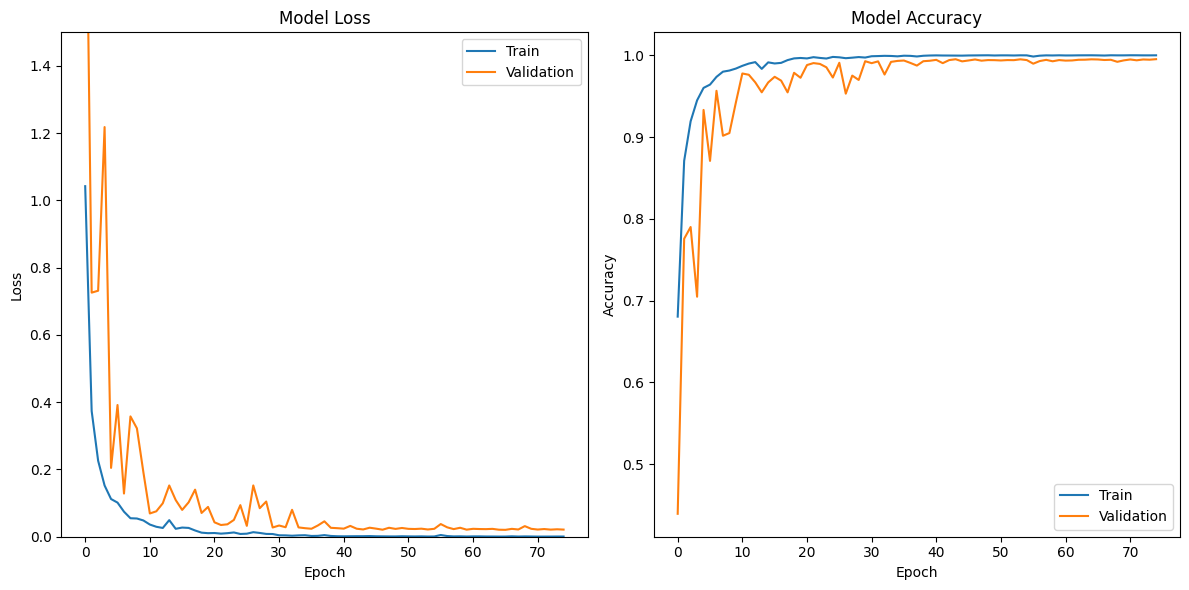

In [22]:
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.ylim(bottom=0, top=1.5)

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.savefig('PlantVillage-2Path-LAB-m4-0.00-History.png')

plt.tight_layout()
plt.show()

In [23]:
import pickle
# Save all histories as a single pickle file (optional)
with open('history_000.pkl', 'wb') as file:
    pickle.dump(history, file)

arr_basefilename = []

for two_paths_second_block in [False, True]:
    for l_ratio in [0.0,0.25,0.5,0.75,1.0]:
        
        basefilename = 'Apple13-twoPath-inception-' + str(two_paths_second_block) + '-' + str(l_ratio)  
        
        arr_basefilename.append(basefilename)
        

print(arr_basefilename)

In [33]:
del save_best

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [44]:
!cp *.png *.hdf5 *.pkl drive/MyDrive/Colab/